In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from functions import *
import gradio as gr


# Importerer filer

In [40]:
folder = 'tmdb-box-office-prediction'

trainingData = pd.read_csv(f'{folder}/train.csv')
testData = pd.read_csv(f'{folder}/test.csv')


# Visualiserer data



In [41]:
trainingData['budget'].value_counts()

budget
0           812
15000000     72
40000000     71
25000000     71
5000000      68
           ... 
747000        1
1119000       1
65000         1
1750000       1
1135654       1
Name: count, Length: 406, dtype: int64

## Fjerner featues som ikke skal brukes

In [43]:

dropFields = ['homepage', 'original_title', 'imdb_id',
              'status', 'title', 'tagline', 'poster_path', 'overview', 'belongs_to_collection']
dropFields2 = ['Keywords', 'cast', 'crew', 'spoken_languages', 'production_countries', 'production_companies', 'genres']
trainingData = trainingData.drop(columns=dropFields + dropFields2)

In [44]:
trainingData.keys() # Ser at vi sitter igjen med korrekte features

Index(['id', 'budget', 'original_language', 'popularity', 'release_date',
       'runtime', 'revenue'],
      dtype='object')

### Konverterer string til int

In [45]:
# Erstatter kategoriten original_language med tall som representerer språk
trainingData.head(10)
trainingData['original_language'].value_counts()

langauges = ['en', 'ja', 'ru', 'fr', 'no', 'ko', 'zh', 'sv', 'cn', 'es', 'id', 'hi', 'it', 'de', 'ta', 'nl', 'pt', 'fa', 'da', 'ro', 'te', 'hu', 'ml', 'pl', 'fi', 'ur', 'he', 'el', 'ar', 'nb', 'vi', 'mr', 'cs', 'sr', 'bn', 'tr']
languageId = [x for x in range(len(langauges))]

trainingData = trainingData.replace(to_replace=langauges, value=languageId)




# Renser dataene

In [46]:
# Konverterer datetime til millisekunder


from datetime import datetime

for key in trainingData['release_date'].keys():
    try:
        date_string = str(trainingData['release_date'][key])

        date_obj = datetime.strptime(date_string, '%m/%d/%y')
        epoch = datetime(1970, 1, 1)
        time_difference = date_obj - epoch

        milliseconds = int(time_difference.total_seconds() * 1000)
        trainingData = trainingData.replace(trainingData['release_date'][key], milliseconds)
    except:
        trainingData = trainingData.drop([key])


# Funksjon som konverterer datetime til millisekunder
def convertToMS(time):

    data_string = str(time)
    
    date_obj = datetime.strptime(date_string, '%m/%d/%y')
    epoch = datetime(1970, 1, 1)
    time_difference = date_obj - epoch

    return int(time_difference.total_seconds() * 1000)

        




In [47]:
# Replace all NaN budget values with mean value

meanVal = trainingData['budget'].mean()


trainingData['budget'].fillna(meanVal, inplace=True)

# Replace all NaN runtime values with mean value
meanVal = trainingData['runtime'].mean()

trainingData['runtime'].fillna(meanVal, inplace=True)



In [48]:
nan_mask = trainingData.isna()

# Ser at det ikke er flere NaN verdier
trainingData[nan_mask.any(axis=1)]


,id,budget,original_language,popularity,release_date,runtime,revenue


# Visualisering av data


[]

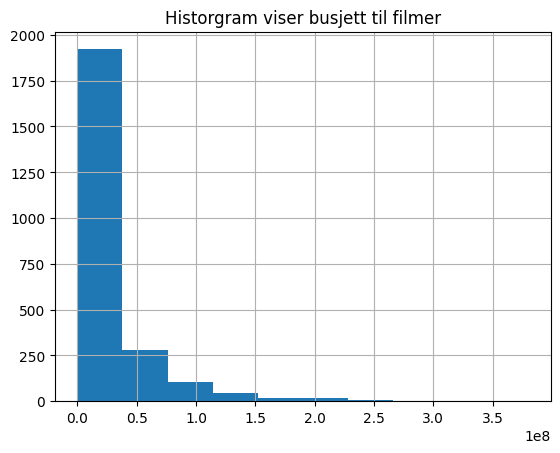

In [49]:
# Visualiserer budget i et historgram
fig, ax = plt.subplots()
trainingData['budget'].hist(ax=ax)
ax.set_xlabel =('Budget')
ax.set_ylabel =('Frequency')
ax.set_title('Historgram viser busjett til filmer')
plt.plot()

### Budsjett mot revenue
Vi kan se at det er en sammenheng her, men ikke helt tydelig alikevell

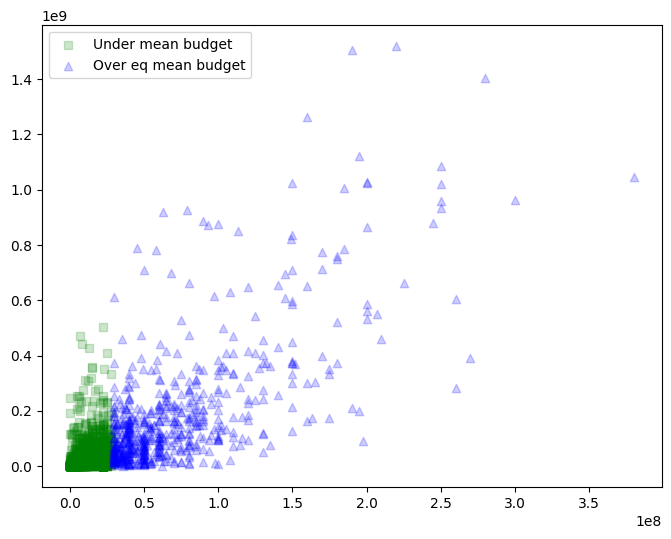

In [13]:
# Sammenligner budsjett mot revenue får å se om det noe korrelasjon her.
budget = trainingData['budget']
meanBudget = budget.mean()
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x=trainingData[budget < meanBudget]['budget'], y=trainingData[budget < meanBudget]['revenue'], marker='s', color='green', label='Under mean budget', alpha=0.2)
ax.scatter(x=trainingData[budget >= meanBudget]['budget'], y=trainingData[budget >= meanBudget]['revenue'], marker='^', color='blue', label='Over eq mean budget', alpha=0.2)
plt.legend()
plt.show()

### Orginalt språk mot revenue

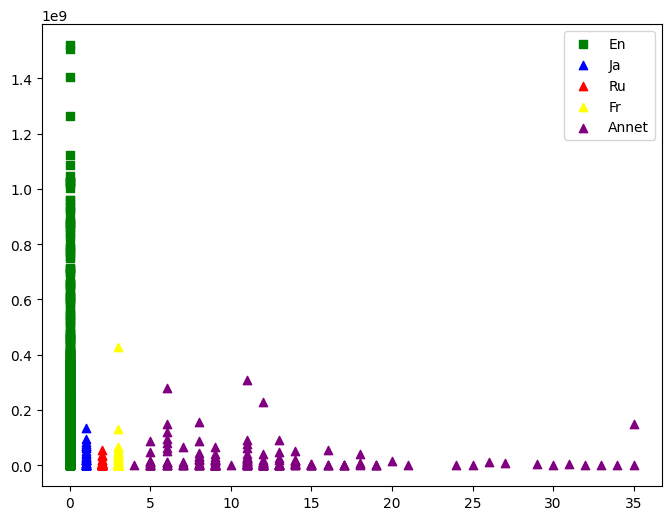

In [15]:
# Skilt ut de 4 språkene som forekommer flest ganger og en for alle andre språk. Vi kan se at engelsk skiller seg ut, men ellers er det noe uklart
lang = trainingData['original_language']
meanBudget = budget.mean()
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(x=trainingData[lang == 0]['original_language'], y=trainingData[lang == 0]['revenue'], marker='s', color='green', label=langauges[0].capitalize())
ax.scatter(x=trainingData[lang == 1]['original_language'], y=trainingData[lang == 1]['revenue'], marker='^', color='blue', label=langauges[1].capitalize())
ax.scatter(x=trainingData[lang == 2]['original_language'], y=trainingData[lang == 2]['revenue'], marker='^', color='red', label=langauges[2].capitalize())
ax.scatter(x=trainingData[lang == 3]['original_language'], y=trainingData[lang == 3]['revenue'], marker='^', color='yellow', label=langauges[3].capitalize())
ax.scatter(x=trainingData[lang >= 4]['original_language'], y=trainingData[lang >= 4]['revenue'], marker='^', color='purple', label='Annet')
plt.legend()
plt.show()

Lager en korrelasjonsmatrise for å se etter sammenhenger

In [16]:
# Ønsket å se om det var noe tydelige sammenhenger, hvor 1 og -1 tilsier sammenheng og nærmere 0 tislier liten sammenheng (ignorerer revenue)
corr_matrix = trainingData.corr()

corr_matrix["revenue"].sort_values(ascending = False)

revenue              1.000000
budget               0.746472
popularity           0.466628
runtime              0.216604
id                   0.020594
release_date         0.014021
original_language   -0.110594
Name: revenue, dtype: float64

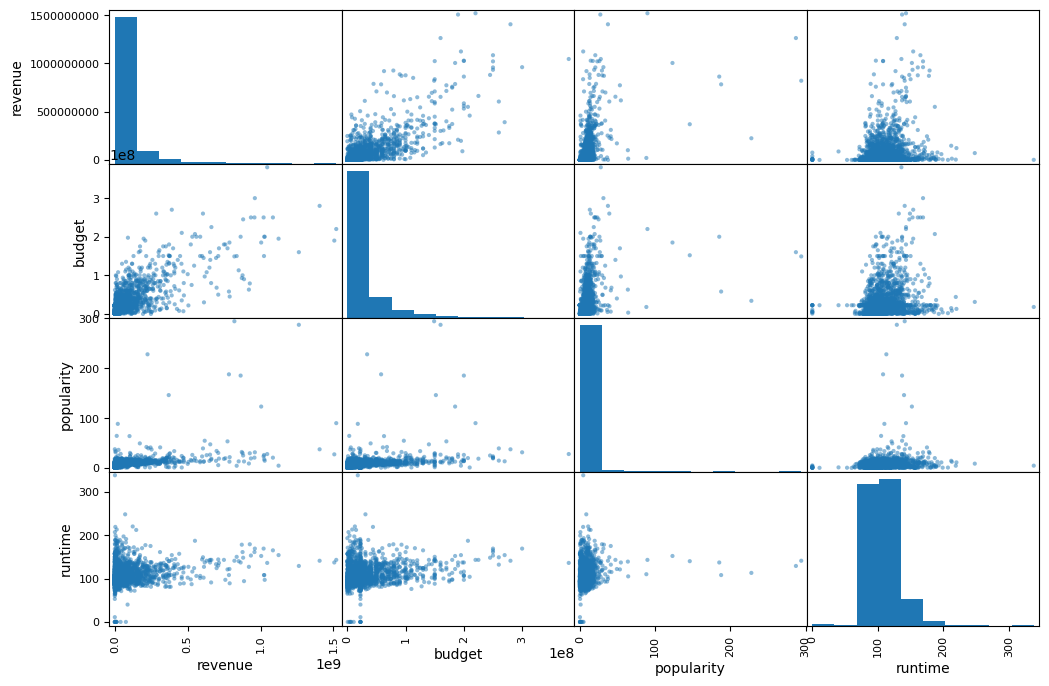

In [17]:
from pandas.plotting import scatter_matrix

#Ønsket å se om det var noe tydelige sammenhenger på de attributene som var nærmest 1
attributes = ["revenue", "budget", "popularity", "runtime"]
scatter_matrix(trainingData[attributes], figsize=(12,8))
plt.show()

Ser ut som runtime viser en tydelig sammenheng rundt midten(men kanskje fordi de fleste filmer varer rundt den lengden?) og at budsjett har en svakt vekst i inntjening, men mye samlet i bunn rundt lavt budsjett

# ML

In [18]:
# Deler opp trainingData i label og henter ut id og legger features i X og label i Y
try:
    label = trainingData['revenue']
    id = trainingData['id']
except:
    pass

features = trainingData.drop(columns={'revenue', 'id'})

X, y = features, label

In [19]:
X.keys()

Index(['budget', 'original_language', 'popularity', 'release_date', 'runtime'], dtype='object')

In [20]:
# Oppretter en dict med alle modellene vi vurderer å bruke

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

models = {"Linear reg":LinearRegression(),
          "Random forest":RandomForestRegressor(n_jobs=-3, random_state=42),
          "Decision tree":DecisionTreeRegressor(),
          "Bayesian ridge": BayesianRidge()}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Finne baseline ytelse og oppførsel

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score

model = RandomForestRegressor(n_jobs=-1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

score = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_squared_error").mean()

loss = -score

loss

9482458837792690.0

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score

models = {"Linear reg":LinearRegression(),
          "Random forest":RandomForestRegressor(n_jobs=-1, random_state=42),
          "Decision tree":DecisionTreeRegressor(),
          "Bayesian ridge": BayesianRidge()}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

values = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

for key in models.keys():
    print(key + ":")
    for value in values:
        

        score = -cross_val_score(models[key], X_train, y_train, cv=3, scoring=value).mean()

        print(f"{value}: {score}")



Linear reg:
neg_mean_squared_error: 8867734745149617.0
neg_mean_absolute_error: 52890028.34942323
r2: -0.6011309216497362
Random forest:
neg_mean_squared_error: 9482458837792690.0
neg_mean_absolute_error: 48520314.22667322
r2: -0.5648697707059933
Decision tree:
neg_mean_squared_error: 1.5547409785947192e+16
neg_mean_absolute_error: 61075224.94139833
r2: -0.24546154086313918
Bayesian ridge:
neg_mean_squared_error: 1.0367698754362612e+16
neg_mean_absolute_error: 57109315.14075634
r2: -0.5314729041058569


Vi kan se at Random Forest kommer best ut av cross validation sett i sin helhet. Vi går derfor videre med denne modellen

In [23]:
model = models['Random forest']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)




## Finne feature importance

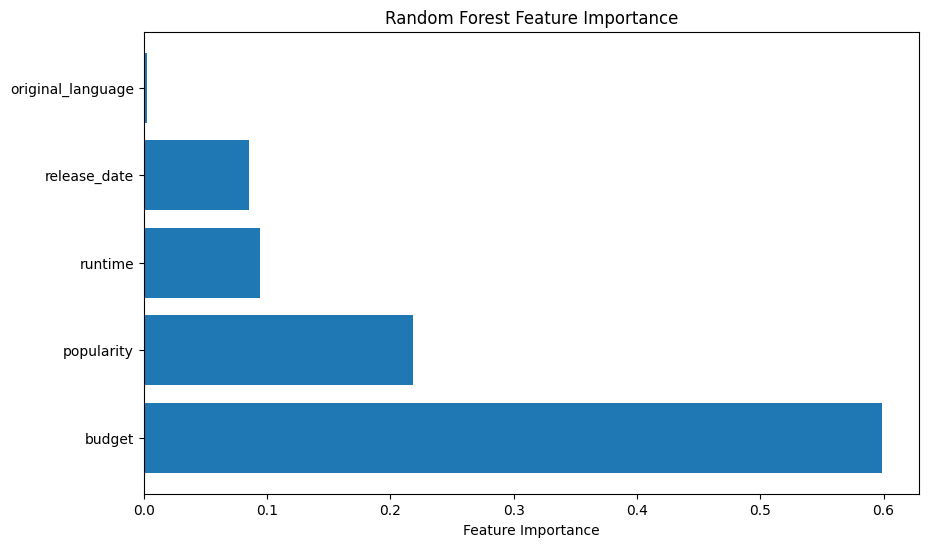

In [24]:
feature_importance = model.feature_importances_

feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))

import matplotlib.pyplot as plt

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


## Visualiserer oppførsel av modellen mot datapunktene

In [25]:
hyperparameters = model.get_params()

# Print the hyperparameters
for param, value in hyperparameters.items():
    print(f"{param}: {value}")

#n_estimators : trær i skogen, max_features : største tall for features før splittes, max_depth : største tallet av level i treet, min_samples_split : minste tallet av datapunkt før noden splittes, min_samples_leaf : minste tallet av datapunkt i en node, bootstrap : metode for sampling av datapunkt

bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: -1
oob_score: False
random_state: 42
verbose: 0
warm_start: False


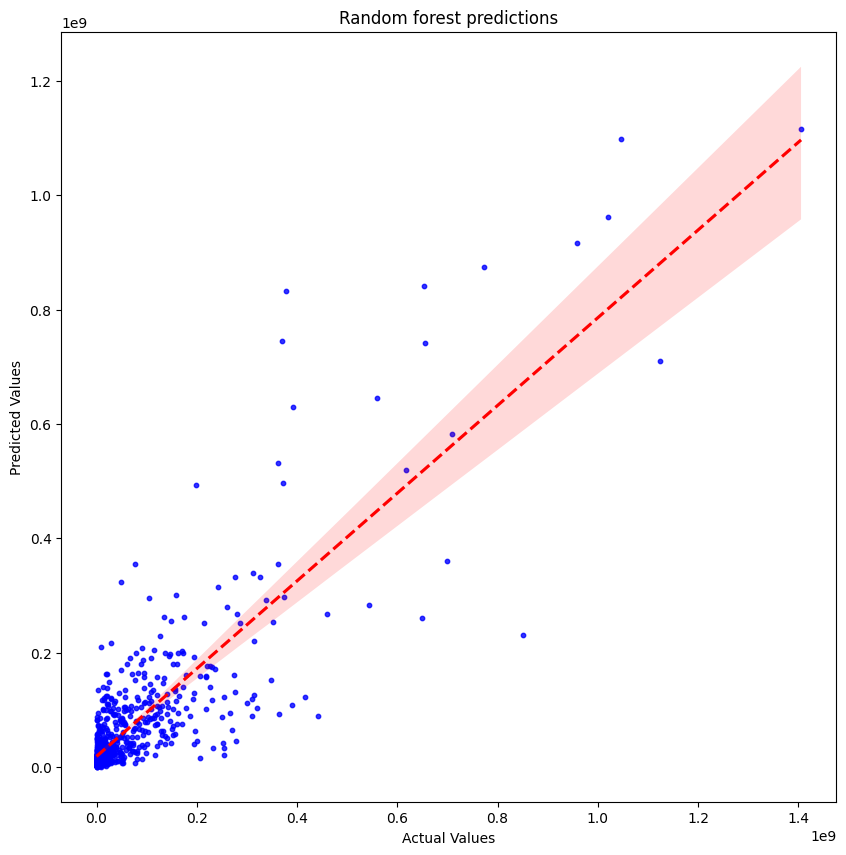

In [26]:
#Kode hentet fra 1.5 - regression notebooken
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'color': 'blue', 's': 10}, line_kws={'color': 'red', 'linestyle': '--'})
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Random forest predictions')
plt.show()

# Prøver å optimalisere hyperparameterene

In [27]:
#bruker randomized search for å korte ned mulige paramterere å tjune
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

#trær i skogen
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#Antall features å vurdere i hver split
max_features = [1, 'sqrt']
#Maks dybde på treet
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#minimum antall prøver for å kunne splitte en node
min_sample_split = [2,5,10]
#minimum antall prøver for hver node
min_samples_leaf = [1,2,4]
#metode for å velge prøver for hvert tre
bootstrap = [True, False]

#Lag en tilfeldig grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split':min_sample_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap':bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': [1, 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [28]:
#Bruker random grid til å søke etter de beste hyperparamterene

model_random = RandomizedSearchCV(estimator= model, param_distributions=random_grid, n_iter=100, cv = 3, verbose = 2, random_state=42, n_jobs=-1)

model_random.fit(X_train, y_train)

model_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=False, max_depth=40, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   2.8s
[CV] END bootstrap=False, max_depth=40, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   2.7s
[CV] END bootstrap=False, max_depth=100, max_features=1, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   2.5s
[CV] END bootstrap=False, max_depth=100, max_features=1, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   2.5s
[CV] END bootstrap=False, max_depth=100, max_features=1, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   3.4s
[CV] END bootstrap=True, max_depth=20, max_fe

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [29]:
def evaluate(modell, test_features, test_labels):
    predictions = modell.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

base_accuracy = evaluate(model, X_test, y_test)
best_random = model_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 40879743.5002 degrees.
Accuracy = -2174661.21%.
Model Performance
Average Error: 39444894.6151 degrees.
Accuracy = -4395147.53%.
Improvement of 102.11%.


In [30]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [33]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.4s
[CV] E

In [34]:
def cleanBeforeGradio(budget, language, popularity, release_date, length):
    language = langauges.index(language)
    release_date_converted = convertToMS(release_date)



    return np.array([budget, language, popularity, release_date_converted, length]).reshape(1, -1)

In [37]:
predictThis = np.array([10000000, 'en', 7.9, '2/12/21', 120.0]).reshape(1, -1)

def predictWithGradio(budget, language, popularity, release_date, length):
    prediction = model.predict(cleanBeforeGradio(budget, language, popularity, release_date, length))
    return prediction[0]

predictWithGradio(10000000, 'en', 7.9, '2/12/21', 120.0)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


22023646.71

# Deploy

In [38]:
interface =gr.Interface(fn = predictWithGradio, 
    outputs=gr.components.Textbox(label="Prediction"),
    inputs=[
        gr.components.Number(label="Budsjett"),
        gr.components.Dropdown(langauges, label="Språk"),
        gr.components.Slider(label="Popularitet", maximum=10.0),
        gr.components.Textbox(label="Dato", placeholder="M/D/YY"),
        gr.components.Slider(label="Runtime (minutes)", maximum=248)
        
        
])
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://802c24a5d28a6f1c56.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
